<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/homework06/homework06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 06

**Overview of the result from Homework 05**
Batch size: 32, Epochs: 10, Optimizer: Adam

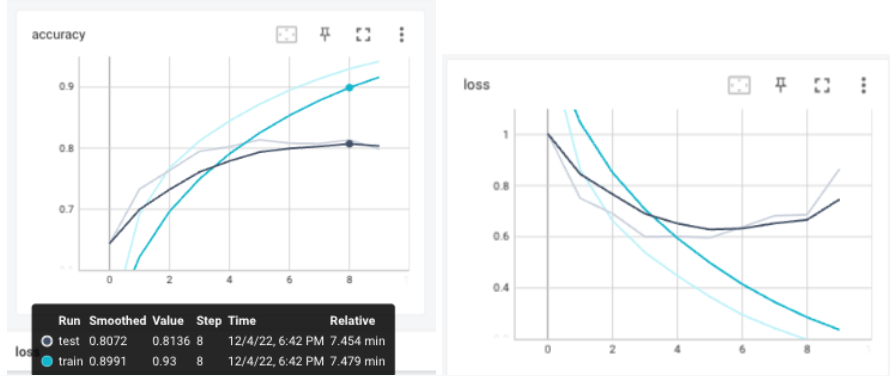

The proposed model on homework 05 has an overfitting on the CIFAR-10 dataset. According to the accuracy and loss plot, the model performs really well in the training data as indicate by high accuracy (around 0.93) and low value of loss (close to 0.1). However, the model cannot maintain its performance in the test data which means unable to generalise the data. It is indicated by the lower accuracy of a value around 0.8 and high loss around 0.7


In [35]:
!pip install tensorflow_datasets tqdm > /dev/null

In [36]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import random

In [37]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Prepare Dataset and Visualisation

In [38]:
# Load CIFAR10 dataset
def load_data():
    (train_ds, test_ds), ds_info = tfds.load('cifar10', 
                                             split=['train', 'test'], 
                                             as_supervised=True, 
                                             with_info=True)
    
    return (train_ds, test_ds), ds_info

In [39]:
# Check Dataset Information
(train_ds,test_ds), ds_info = load_data()

2022-12-11 17:09:31.807994: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


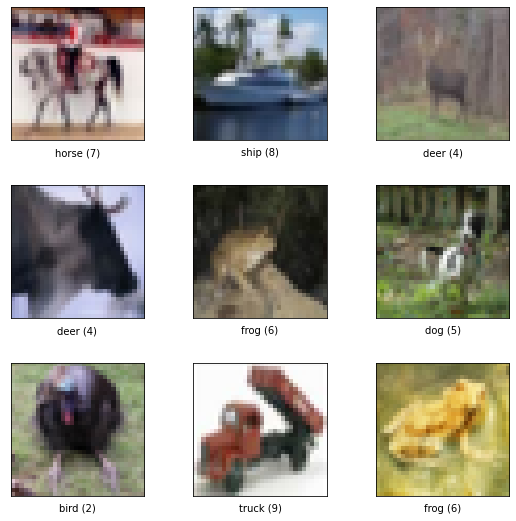

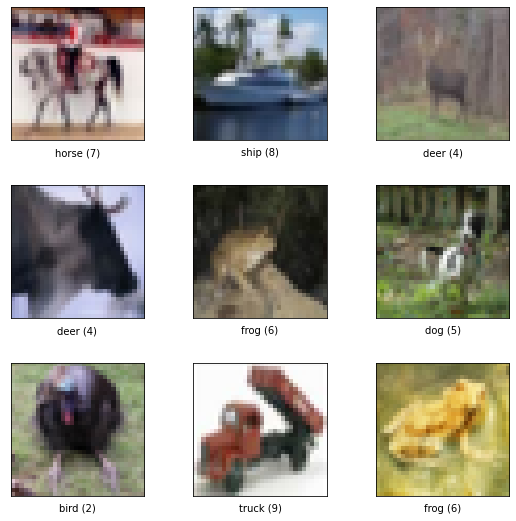

In [40]:
# Visualising dataset
tfds.show_examples(train_ds, ds_info)

**About dataset**:
- 32x32 colour images
- training: 50,000
- test: 10,000
- label: 10 categories
- datatype: tf.uint8

In [41]:
def preprocess(data, augment=False, input_normalisation=False):
  # convert (uint8 to float32)
  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
  
  if input_normalisation:
    data = data.map(lambda img, target: (tf.image.per_image_standardization(img),target))
  else:
    # normalisation ( [0, 255] to [-1, 1] )
    data = data.map(lambda img, target: ((img/128.)-1., target))

  # create one-hot targets (10 classes)
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  
  # caching transformation on dataset 
  data = data.cache()
  
  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(32)
  
  if augment:
    # flip each image left-right with a chance of 0.3
    data = data.map(lambda img, target: (tf.reverse(img, axis=[-2]), target) if random.random() < 0.3 else (img, target))
    # flip each image upside-down with a chance of 0.3
    data = data.map(lambda img, target: (tf.reverse(img, axis=[-3]), target) if random.random() < 0.3 else (img, target))


  data = data.prefetch(tf.data.AUTOTUNE)
  
  #return preprocessed dataset
  return data

In [42]:
# Apply function prepare_data to dataset
train_ds = train_ds.apply(preprocess)
test_ds = test_ds.apply(preprocess)

### Training loop

In [43]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range (epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0,leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in test_ds:
            model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")
    
    model.save_weights(save_path)

## The Densenet Model augmented with optional regularization options

In [44]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernel_regularizer=None):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer)

  def call(self, x):
    c = self.conv(x)
    # not taking it as output but concatinating them
    # then will be stacking all the way to the next layer
    x = tf.concat((x,c), axis=-1) 
    return x

class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers, kernel_regularizer=None, batch_norm=False):
    super().__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters, kernel_regularizer) for _ in range(layers)]
    if batch_norm:
      self.layers.append(tf.keras.layers.BatchNormalization())
  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class CNN(tf.keras.Model):
  def __init__(self, optimizer, loss_function, L2_reg=0, dropout_rate=0, batch_norm=False):
    self.dropout_rate = dropout_rate
    super().__init__()
    kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
    # num_filters = 24 / n layers = 4
    self.denseblock1 = DenselyConnectedCNNBlock(24,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.pooling1 = tf.keras.layers.MaxPooling2D()
    # 16x16 resolution (from original 32 x 32)
    self.denseblock2 = DenselyConnectedCNNBlock(48,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.pooling2 = tf.keras.layers.MaxPooling2D()
    # 8x8 resolution (from input 16 x 16)
    self.denseblock3 = DenselyConnectedCNNBlock(96,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')
    if self.dropout_rate:
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    self.optimizer = optimizer
    self.loss_function = loss_function

    self.metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Mean(name="loss")
    ]

  def call(self, x, training=False):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    if self.dropout_rate:
      x = self.dropout_layer(x, training)
    return x

  # reset all metrics
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()
  @tf.function
  def train_step(self, data):
      image, label = data

      with tf.GradientTape() as tape:
          prediction = self(image, training = True)
          loss = self.loss_function(label, prediction)

      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)

  @tf.function
  def test_step(self, data):
      image, label = data
      prediction = self(image, training = False)
      loss = self.loss_function(label, prediction)
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)



## Training the Densenet Model from hw05 without any extra optimisation

In [45]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_no_optimisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:16<00:00, 92.32it/s] 


Epoch:  1
Loss:  1.3905083 Accuracy:  0.489 (Train)
Loss:  1.0247246 Accuracy:  0.6335 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.80it/s]


Epoch:  2
Loss:  0.8943392 Accuracy:  0.6818 (Train)
Loss:  0.8416112 Accuracy:  0.708 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.03it/s]


Epoch:  3
Loss:  0.68621707 Accuracy:  0.7592 (Train)
Loss:  0.7124938 Accuracy:  0.748 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.73it/s]


Epoch:  4
Loss:  0.55373347 Accuracy:  0.80574 (Train)
Loss:  0.62696517 Accuracy:  0.7878 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.78it/s]


Epoch:  5
Loss:  0.457306 Accuracy:  0.84106 (Train)
Loss:  0.66404325 Accuracy:  0.7887 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.06it/s]


Epoch:  6
Loss:  0.37863 Accuracy:  0.86576 (Train)
Loss:  0.60470915 Accuracy:  0.809 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.26it/s]


Epoch:  7
Loss:  0.30949906 Accuracy:  0.89146 (Train)
Loss:  0.7093491 Accuracy:  0.8008 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.23it/s]


Epoch:  8
Loss:  0.25171828 Accuracy:  0.91036 (Train)
Loss:  0.7063739 Accuracy:  0.8094 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 104.01it/s]


Epoch:  9
Loss:  0.20460607 Accuracy:  0.92762 (Train)
Loss:  0.729191 Accuracy:  0.815 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.78it/s]


Epoch:  10
Loss:  0.16923143 Accuracy:  0.9391 (Train)
Loss:  0.8422973 Accuracy:  0.8107 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.74it/s]


Epoch:  11
Loss:  0.14377594 Accuracy:  0.94898 (Train)
Loss:  0.91722727 Accuracy:  0.8057 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.07it/s]


Epoch:  12
Loss:  0.12804277 Accuracy:  0.95388 (Train)
Loss:  0.8630682 Accuracy:  0.8066 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.04it/s]


Epoch:  13
Loss:  0.11471623 Accuracy:  0.95892 (Train)
Loss:  0.9407093 Accuracy:  0.8036 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.13it/s]


Epoch:  14
Loss:  0.10458229 Accuracy:  0.96272 (Train)
Loss:  0.99512345 Accuracy:  0.8094 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.20it/s]


Epoch:  15
Loss:  0.10171314 Accuracy:  0.96478 (Train)
Loss:  1.0006939 Accuracy:  0.8034 (Test)


# Optimisations

## Optimisation 1 - Data Augmentation
**Data augmentation is** a method to introduce diversity in the training set by adding the transformation from the data itself. In image processing, followings are common ways to augment the data: gray scalling, zooming, cropping, flipping, color modification, geometric tranformation, etc.

Data augmentation has following **advantages**: [[source]](https://www.analyticssteps.com/blogs/data-augmentation-techniques-benefits-and-applications)
* reducing cost in data collection and labelling
* preventing data scarcity as it maintains imbalance issue

Meanwhile, it has main **limitation** in causing the distribution of data to be different from original dataset.[[source]](https://arxiv.org/pdf/2010.01267.pdf)

In [46]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, augment=True)
test_ds = preprocess(test_ds)

epochs = 15

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)

optimisation_name = 'densenet_data-augmentation'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

# Running training loop
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:17<00:00, 90.79it/s] 


Epoch:  1
Loss:  1.3972409 Accuracy:  0.48582 (Train)
Loss:  1.0447714 Accuracy:  0.6266 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  2
Loss:  0.89335257 Accuracy:  0.6817 (Train)
Loss:  0.7742373 Accuracy:  0.7257 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.40it/s]


Epoch:  3
Loss:  0.6897747 Accuracy:  0.75686 (Train)
Loss:  0.72444755 Accuracy:  0.7554 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.23it/s]


Epoch:  4
Loss:  0.5635731 Accuracy:  0.80318 (Train)
Loss:  0.6043732 Accuracy:  0.7969 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.11it/s]


Epoch:  5
Loss:  0.4696816 Accuracy:  0.83384 (Train)
Loss:  0.59639525 Accuracy:  0.8036 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 104.17it/s]


Epoch:  6
Loss:  0.3845615 Accuracy:  0.86498 (Train)
Loss:  0.636134 Accuracy:  0.7925 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 104.04it/s]


Epoch:  7
Loss:  0.31019378 Accuracy:  0.88992 (Train)
Loss:  0.60502964 Accuracy:  0.8186 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.61it/s]


Epoch:  8
Loss:  0.25360712 Accuracy:  0.90868 (Train)
Loss:  0.63407314 Accuracy:  0.8216 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.34it/s]


Epoch:  9
Loss:  0.20891285 Accuracy:  0.92538 (Train)
Loss:  0.7729993 Accuracy:  0.8065 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.26it/s]


Epoch:  10
Loss:  0.16983724 Accuracy:  0.94004 (Train)
Loss:  0.76794016 Accuracy:  0.8145 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.76it/s]


Epoch:  11
Loss:  0.14353514 Accuracy:  0.94822 (Train)
Loss:  0.84172356 Accuracy:  0.8147 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 104.02it/s]


Epoch:  12
Loss:  0.12716717 Accuracy:  0.9553 (Train)
Loss:  0.8936274 Accuracy:  0.8126 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 103.85it/s]


Epoch:  13
Loss:  0.11540794 Accuracy:  0.95898 (Train)
Loss:  0.9828221 Accuracy:  0.8051 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.49it/s]


Epoch:  14
Loss:  0.10301338 Accuracy:  0.96368 (Train)
Loss:  0.9342575 Accuracy:  0.809 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.38it/s]


Epoch:  15
Loss:  0.09712851 Accuracy:  0.9663 (Train)
Loss:  0.95127124 Accuracy:  0.8127 (Test)


## Optimisation 2 - Dropout
Dropout techniques helps agains overfitting by removing a percentage of neurons from the output of a layer. At every training step each neuron has a chance of being left out. That way, we reduce dependency of our resulting model on all interconnected neurons and give a space for generalisation.  

However, the dropout layer has a drawback of introducing more hyperparameter at each layer thats needs to be finetuned to reach optimal performance [[source]](http://proceedings.mlr.press/v97/wang19q/wang19q.pdf)

In [51]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, augment=False)
test_ds = preprocess(test_ds)

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, dropout_rate=0.2)
epochs = 15

optimisation_name = 'densenet_dropout-layer'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

# Running training loop
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:17<00:00, 87.54it/s] 


Epoch:  1
Loss:  4.237593 Accuracy:  0.41412 (Train)
Loss:  1.1407773 Accuracy:  0.592 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.55it/s]


Epoch:  2
Loss:  3.8672135 Accuracy:  0.55832 (Train)
Loss:  0.8595309 Accuracy:  0.691 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.23it/s]


Epoch:  3
Loss:  3.7466447 Accuracy:  0.6083 (Train)
Loss:  0.7203904 Accuracy:  0.7514 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.21it/s]


Epoch:  4
Loss:  3.6415904 Accuracy:  0.64336 (Train)
Loss:  0.71758455 Accuracy:  0.7513 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  5
Loss:  3.6143556 Accuracy:  0.66328 (Train)
Loss:  0.6768857 Accuracy:  0.7666 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 107.11it/s]


Epoch:  6
Loss:  3.565788 Accuracy:  0.68042 (Train)
Loss:  0.60123247 Accuracy:  0.797 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 107.03it/s]


Epoch:  7
Loss:  3.4874372 Accuracy:  0.69932 (Train)
Loss:  0.63769287 Accuracy:  0.7905 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.60it/s]


Epoch:  8
Loss:  3.453195 Accuracy:  0.71372 (Train)
Loss:  0.67236674 Accuracy:  0.7953 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.61it/s]


Epoch:  9
Loss:  3.43768 Accuracy:  0.72402 (Train)
Loss:  0.6565552 Accuracy:  0.8086 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.51it/s]


Epoch:  10
Loss:  3.3727975 Accuracy:  0.73562 (Train)
Loss:  0.7479123 Accuracy:  0.7919 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 106.62it/s]


Epoch:  11
Loss:  3.3765633 Accuracy:  0.74388 (Train)
Loss:  0.7278257 Accuracy:  0.8008 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.93it/s]


Epoch:  12
Loss:  3.4358547 Accuracy:  0.74686 (Train)
Loss:  0.8027514 Accuracy:  0.7917 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  13
Loss:  3.366048 Accuracy:  0.75456 (Train)
Loss:  0.79097027 Accuracy:  0.8053 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.37it/s] 


Epoch:  14
Loss:  3.3323386 Accuracy:  0.75972 (Train)
Loss:  0.8224226 Accuracy:  0.8006 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  15
Loss:  3.3572726 Accuracy:  0.76116 (Train)
Loss:  0.8433884 Accuracy:  0.8084 (Test)


## Optimisation 3 - L2 Regularisation
L2 regularisation  helps against overfitting by tackling the problem of large weights. The loss is penalised by the coefficient multiplied by square of the weight. This way, smaller weights are preferred. 
L2 works better against overfitting than L1. 


In [48]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_l2-regularisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, L2_reg=0.001)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:17<00:00, 88.61it/s] 


Epoch:  1
Loss:  1.390576 Accuracy:  0.49364 (Train)
Loss:  1.0328474 Accuracy:  0.6326 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.32it/s]


Epoch:  2
Loss:  0.8885613 Accuracy:  0.68456 (Train)
Loss:  0.81802845 Accuracy:  0.7056 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.81it/s]


Epoch:  3
Loss:  0.69033027 Accuracy:  0.75942 (Train)
Loss:  0.6927137 Accuracy:  0.7611 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  4
Loss:  0.56780887 Accuracy:  0.80168 (Train)
Loss:  0.6485146 Accuracy:  0.7775 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.95it/s]


Epoch:  5
Loss:  0.4742258 Accuracy:  0.83526 (Train)
Loss:  0.59167063 Accuracy:  0.8036 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.09it/s]


Epoch:  6
Loss:  0.39226586 Accuracy:  0.86226 (Train)
Loss:  0.61036104 Accuracy:  0.8037 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.62it/s]


Epoch:  7
Loss:  0.32808965 Accuracy:  0.88468 (Train)
Loss:  0.62724155 Accuracy:  0.8059 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.34it/s]


Epoch:  8
Loss:  0.26554638 Accuracy:  0.9076 (Train)
Loss:  0.6482659 Accuracy:  0.8142 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.59it/s]


Epoch:  9
Loss:  0.21959607 Accuracy:  0.92204 (Train)
Loss:  0.70196843 Accuracy:  0.8105 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 104.11it/s]


Epoch:  10
Loss:  0.17892267 Accuracy:  0.93714 (Train)
Loss:  0.7691955 Accuracy:  0.8121 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 103.98it/s]


Epoch:  11
Loss:  0.15287058 Accuracy:  0.94722 (Train)
Loss:  0.76993954 Accuracy:  0.8122 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.46it/s]


Epoch:  12
Loss:  0.13660358 Accuracy:  0.95204 (Train)
Loss:  0.8055183 Accuracy:  0.8185 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.68it/s]


Epoch:  13
Loss:  0.11699943 Accuracy:  0.95792 (Train)
Loss:  1.0215498 Accuracy:  0.7962 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.41it/s]


Epoch:  14
Loss:  0.10495337 Accuracy:  0.96344 (Train)
Loss:  1.003285 Accuracy:  0.799 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.96it/s]


Epoch:  15
Loss:  0.09972221 Accuracy:  0.96496 (Train)
Loss:  1.1068208 Accuracy:  0.8005 (Test)


## Optimisation 4 - Batch normalisation
We use BatchNorm to normalize the activations of the channels in the last convolutional layer of our convolutional layer blocks. This brings the activations closer to a standard normal distribution. When all channel activations have activations of the same scale, the gradients will also be of the same scale and it will be easier to learn for the network. In the long run, batch normalisation can also help against vanishing/exploding gradients. 

In [49]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_batch-normalisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, batch_norm=True)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:18<00:00, 83.97it/s]


Epoch:  1
Loss:  1.132362 Accuracy:  0.597 (Train)
Loss:  0.9662742 Accuracy:  0.6749 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.75it/s] 


Epoch:  2
Loss:  0.6754047 Accuracy:  0.76644 (Train)
Loss:  0.70407593 Accuracy:  0.7592 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.84it/s]


Epoch:  3
Loss:  0.4902764 Accuracy:  0.83122 (Train)
Loss:  0.7568282 Accuracy:  0.7475 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.90it/s]


Epoch:  4
Loss:  0.36629 Accuracy:  0.8751 (Train)
Loss:  0.56887877 Accuracy:  0.8114 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.91it/s]


Epoch:  5
Loss:  0.2690127 Accuracy:  0.9077 (Train)
Loss:  0.65797377 Accuracy:  0.8106 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.83it/s] 


Epoch:  6
Loss:  0.1996876 Accuracy:  0.9304 (Train)
Loss:  0.58180845 Accuracy:  0.828 (Test)


100%|██████████| 1563/1563 [00:16<00:00, 97.58it/s]


Epoch:  7
Loss:  0.15167448 Accuracy:  0.94708 (Train)
Loss:  0.7194068 Accuracy:  0.8221 (Test)


100%|██████████| 1563/1563 [00:16<00:00, 97.44it/s]


Epoch:  8
Loss:  0.12101632 Accuracy:  0.95828 (Train)
Loss:  0.6526335 Accuracy:  0.8271 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s]


Epoch:  9
Loss:  0.09884927 Accuracy:  0.9655 (Train)
Loss:  0.6934966 Accuracy:  0.837 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 98.42it/s]


Epoch:  10
Loss:  0.09020062 Accuracy:  0.96794 (Train)
Loss:  0.6784235 Accuracy:  0.8375 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 98.00it/s]


Epoch:  11
Loss:  0.07910578 Accuracy:  0.97232 (Train)
Loss:  0.7105246 Accuracy:  0.8324 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.95it/s] 


Epoch:  12
Loss:  0.0753429 Accuracy:  0.97328 (Train)
Loss:  0.7124824 Accuracy:  0.841 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 97.73it/s]


Epoch:  13
Loss:  0.06317217 Accuracy:  0.97854 (Train)
Loss:  0.7210327 Accuracy:  0.8389 (Test)


100%|██████████| 1563/1563 [00:16<00:00, 97.56it/s] 


Epoch:  14
Loss:  0.06268488 Accuracy:  0.97878 (Train)
Loss:  0.81250846 Accuracy:  0.8336 (Test)


100%|██████████| 1563/1563 [00:15<00:00, 98.19it/s]


Epoch:  15
Loss:  0.06034733 Accuracy:  0.97844 (Train)
Loss:  0.7314755 Accuracy:  0.843 (Test)


## Optimisation 5 - Input Normalisation
We already use an approximated input normalization in our preprocessed function. This approximated function is not exactly centered around 0 and the values are bound between -1 and 1. In this input normalization, we make the mean=0 and will have a standard deviation of 1.
It will be interesting to see, how good the approximation to the "real" input normalisation will be!
Normalising the input around 0 with a small standard deviation is always a good idea in image data, because pixel values between 0 and 255 can lead to high activations and gradients which can lead to problems in learning.  


In [50]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, input_normalisation=True)
test_ds = preprocess(test_ds, input_normalisation=True)

optimisation_name = 'densenet-input-normalisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

100%|██████████| 1563/1563 [00:17<00:00, 87.76it/s] 


Epoch:  1
Loss:  1.3308663 Accuracy:  0.5147 (Train)
Loss:  0.99374753 Accuracy:  0.6459 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.36it/s]


Epoch:  2
Loss:  0.8290372 Accuracy:  0.70882 (Train)
Loss:  0.73008233 Accuracy:  0.743 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.57it/s]


Epoch:  3
Loss:  0.63410336 Accuracy:  0.7803 (Train)
Loss:  0.661868 Accuracy:  0.7739 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.85it/s]


Epoch:  4
Loss:  0.51119006 Accuracy:  0.82202 (Train)
Loss:  0.60464835 Accuracy:  0.7953 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.49it/s]


Epoch:  5
Loss:  0.41053075 Accuracy:  0.856 (Train)
Loss:  0.7341195 Accuracy:  0.7707 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.70it/s]


Epoch:  6
Loss:  0.33127618 Accuracy:  0.883 (Train)
Loss:  0.62299323 Accuracy:  0.8162 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.66it/s]


Epoch:  7
Loss:  0.26933345 Accuracy:  0.90568 (Train)
Loss:  0.63851327 Accuracy:  0.8211 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.45it/s]


Epoch:  8
Loss:  0.20826145 Accuracy:  0.92746 (Train)
Loss:  0.70135057 Accuracy:  0.8194 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.23it/s]


Epoch:  9
Loss:  0.17145994 Accuracy:  0.93908 (Train)
Loss:  0.8148449 Accuracy:  0.8127 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.13it/s]


Epoch:  10
Loss:  0.14216012 Accuracy:  0.94992 (Train)
Loss:  0.8951264 Accuracy:  0.8016 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.10it/s]


Epoch:  11
Loss:  0.12429476 Accuracy:  0.95682 (Train)
Loss:  1.0008554 Accuracy:  0.8028 (Test)


100%|██████████| 1563/1563 [00:20<00:00, 76.38it/s] 


Epoch:  12
Loss:  0.114427395 Accuracy:  0.95956 (Train)
Loss:  0.85441685 Accuracy:  0.8165 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.43it/s]


Epoch:  13
Loss:  0.097145766 Accuracy:  0.96694 (Train)
Loss:  1.1422024 Accuracy:  0.8017 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 105.02it/s]


Epoch:  14
Loss:  0.10213226 Accuracy:  0.96448 (Train)
Loss:  0.96934867 Accuracy:  0.8138 (Test)


100%|██████████| 1563/1563 [00:14<00:00, 104.87it/s]


Epoch:  15
Loss:  0.081933126 Accuracy:  0.97218 (Train)
Loss:  1.04958 Accuracy:  0.8232 (Test)


## Visualisation
https://tensorboard.dev/experiment/BAA4rVzWQTyq82pvFn8uyA/